#  ARF6, XPO5, CYTH3 on melanoma patient survival
Using Xena python to get patient clinical data and corresponding gene expression data.<br />
Using Scikit-survival to analyze ARF6, XPO5, CYTH3's role in survival.

In [ ]:
"""
Built in python2 environment
If not install, those modules are needed
!pip install xenaPython
!pip install scikit-survival
"""
# Pre-defined methods from Xena doc
import xenaPython as xena

def get_codes(host, dataset, fields, data):
    "get codes for enumerations"
    codes = xena.field_codes(host, dataset, fields)
    codes_idx = dict([(x['name'], x['code'].split('\t')) for x in codes if x['code'] is not None])
    for i in range(len(fields)):
        if fields[i] in codes_idx:
            data[i] = [None if v == 'NaN' else codes_idx[fields[i]][int(v)] for v in data[i]]
    return data

def get_fields(host, dataset, samples, fields):
    "get field values"
    data = xena.dataset_fetch(host, dataset, samples, fields)
    return data

def get_fields_and_codes(host, dataset, samples, fields):
    "get fields and resolve codes"
    return get_codes( host, dataset, fields, get_fields( host, dataset, samples, fields))

# This part aims to get the data via Xena and clear the data

In [127]:
# Define the genes of interest
GENES = ['ARF6', 'CYTH3', 'XPO5']

# Define patient cohort, host url and specific dataset
cohort = 'TCGA Melanoma (SKCM)'
host = "https://tcga.xenahubs.net"
dataset = 'TCGA.SKCM.sampleMap/HiSeqV2'

# get samples in cohort and display the first 10
samples = xena.cohort_samples(host, cohort, None)
samples[0: 10]


['TCGA-EE-A29Q-06',
 'TCGA-EE-A181-06',
 'TCGA-D9-A1JW-06',
 'TCGA-D3-A3CE-06',
 'TCGA-D3-A8GB-06',
 'TCGA-D3-A2JP-06',
 'TCGA-W3-A828-06',
 'TCGA-Z2-A8RT',
 'TCGA-ER-A195-06',
 'TCGA-D3-A51J-06']

In [128]:
# Getting gene expression data for the patient cohort
expression = get_fields(hub, dataset, samples, GENES) # list of lists.
expression_by_gene = dict(zip(GENES, expression))      # index by gene.
[expression_by_gene.keys(), GENES[2], expression_by_gene[GENES[2]][0:10]]

[dict_keys(['ARF6', 'CYTH3', 'XPO5']),
 'XPO5',
 [10.01, 11.71, 11.63, 10.7, 10.04, 10.04, 9.959, 'NaN', 10.77, 10.41]]

In [129]:
# Getting the patient clinical data will be used in survival analysis

clinicDataset = 'TCGA.SKCM.sampleMap/SKCM_clinicalMatrix'
fields = ['sampleID','_TIME_TO_EVENT','_EVENT']
values = get_fields_and_codes(host, clinicDataset, samples, fields) 
phenotypes = dict(zip(fields, values)) 

# Take a peak of the data and find the datatype and missing values
phenotypes

{'sampleID': ['TCGA-EE-A29Q-06',
  'TCGA-EE-A181-06',
  'TCGA-D9-A1JW-06',
  'TCGA-D3-A3CE-06',
  'TCGA-D3-A8GB-06',
  'TCGA-D3-A2JP-06',
  'TCGA-W3-A828-06',
  None,
  'TCGA-ER-A195-06',
  'TCGA-D3-A51J-06',
  None,
  'TCGA-EE-A2M6-06',
  'TCGA-GN-A264-06',
  'TCGA-GF-A3OT-06',
  None,
  None,
  None,
  None,
  None,
  'TCGA-D3-A5GR-06',
  'TCGA-D3-A8GM-06',
  'TCGA-FR-A7U8-06',
  None,
  'TCGA-EB-A3XF-01',
  'TCGA-HR-A2OH-01',
  'TCGA-EE-A2A1-06',
  'TCGA-HR-A2OH-06',
  'TCGA-DA-A95Y-06',
  None,
  'TCGA-FR-A3YO-06',
  'TCGA-ER-A2NE-06',
  'TCGA-ER-A19K-01',
  'TCGA-BF-A3DJ-01',
  'TCGA-D9-A4Z2-01',
  'TCGA-WE-A8K4-01',
  'TCGA-EE-A3AE-06',
  None,
  'TCGA-EE-A2ML-06',
  'TCGA-EE-A2GD-06',
  'TCGA-EB-A5SG-06',
  'TCGA-FS-A1ZA-06',
  'TCGA-BF-AAP8-01',
  'TCGA-EB-A24C-01',
  None,
  'TCGA-XV-AAZY-01',
  'TCGA-EB-A4OY-01',
  'TCGA-RP-A6K9-06',
  'TCGA-EB-A4IQ-01',
  'TCGA-FW-A3TV-06',
  None,
  'TCGA-BF-A5ES-01',
  'TCGA-EE-A29G-06',
  'TCGA-D3-A2JF-06',
  'TCGA-D9-A3Z4-01',
  'TCGA-D3

In [131]:
# Put the data together the for CYTH3, ARF6 greater than 0 classified as high <0 classified aslow, _event: True or false, _day to event
# Covert Arf6 and CYTH3 data to csv for future use

import pandas as pd

# Lists to store the patient info and ARF6, XPO5, CYTH3 expression levels
patient = []
ARF6 = []
CYTH3 = []
XPO5 = []
Status = []
event = []
Survival_in_days = []
cnt = 0
for i in range(len(expression_by_gene["CYTH3"])):
    #if gene expression data or patient data is not available, the patient data will be skipped
    if phenotypes["_TIME_TO_EVENT"][i] == "NaN" or expression_by_gene["CYTH3"][i] == "NaN" or expression_by_gene["ARF6"][i] == "NaN" or expression_by_gene["XPO5"][i] == "NaN" or phenotypes['sampleID'][i] == None or phenotypes['_EVENT'][i] == 'NaN':
        continue
    XPO5.append(expression_by_gene["XPO5"][i])
    ARF6.append(expression_by_gene["ARF6"][i])
    CYTH3.append(expression_by_gene["CYTH3"][i])
    patient.append(phenotypes['sampleID'][i])
    Status.append(phenotypes['_EVENT'][i] == "1")
    Survival_in_days.append(phenotypes['_TIME_TO_EVENT'][i])
    cnt+=1

# Store the info above to a df and store as csv 
df =pd.DataFrame({"patient": patient, "ARF6": ARF6, "CYTH3": CYTH3,  "XPO5" : XPO5, "Status": Status, "Survival_in_days":Survival_in_days}, index = range(cnt))
df.head()
df.to_csv("ARF6 CYTH3 XPO5 cancer survival", sep='\t')

# Starting patient survival analysis

In [133]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
%matplotlib inline
import numpy as np

survival = pd.read_csv("ARF6 CYTH3 XPO5 cancer survival",sep = "\t")

# Take a peak of the data
survival.head()

,Unnamed: 0,patient,ARF6,CYTH3,XPO5,Status,Survival_in_days
0,0,TCGA-EE-A29Q-06,11.51,12.21,10.01,True,2030
1,1,TCGA-EE-A181-06,11.55,11.03,11.71,True,1026
2,2,TCGA-D9-A1JW-06,11.49,12.22,11.63,False,111
3,3,TCGA-D3-A3CE-06,11.10,11.33,10.70,True,1832
4,4,TCGA-D3-A8GB-06,11.46,12.05,10.04,True,938


In [106]:
# Check how many patients we are looking at and the std of the gene expression
survival.describe()

,Unnamed: 0,ARF6,CYTH3,XPO5,Survival_in_days
count,462.000000,462.000000,462.000000,462.000000,462.000000
mean,230.500000,11.454885,11.887942,11.063338,1842.989177
std,133.512172,0.526030,1.054748,0.663200,1933.077769
min,0.000000,9.665000,8.384000,9.271000,6.000000
25%,115.250000,11.112500,11.240000,10.590000,493.500000
50%,230.500000,11.495000,11.865000,11.025000,1124.000000
75%,345.750000,11.800000,12.630000,11.527500,2393.250000
max,461.000000,13.050000,15.200000,12.940000,11252.000000


In [138]:
   
# Def the function to plot the kaplan meier curve of melanoma patients with the gene differentially expressed
def plot_kaplan_meier(gene):
    # Get the media expression of the gene
    median =  np.median(survival[gene])

    # Extract paitent data for CYTH3 low
    survival_low = survival[survival[gene] < median]

    # Extrace patient data for CYTH3 high
    survival_high = survival[survival[gene] > median]

    # Use kaplan_meier_estimator to get the estimated prob and plot the curve 
    time_low, survival_prob_low = kaplan_meier_estimator(survival_low["Status"], survival_low["Survival_in_days"])
    time_high, survival_prob_high = kaplan_meier_estimator(survival_high["Status"], survival_high["Survival_in_days"])
    plt.step(time_low, survival_prob_low, where="post",color = "green")
    plt.step(time_high, survival_prob_high, where="post", color = "red")
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.title(gene + " melanoma survival analysis")
    plt.show()

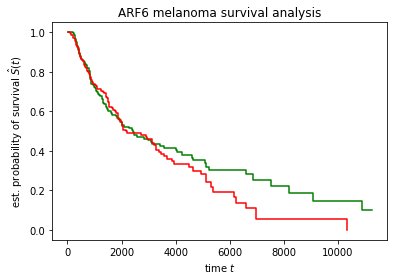

In [139]:
plot_kaplan_meier("ARF6")

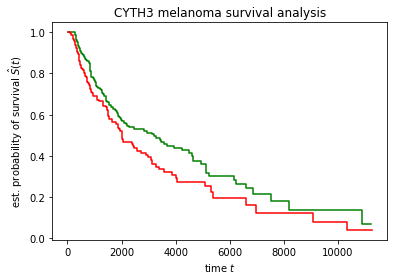

In [140]:
plot_kaplan_meier("CYTH3")

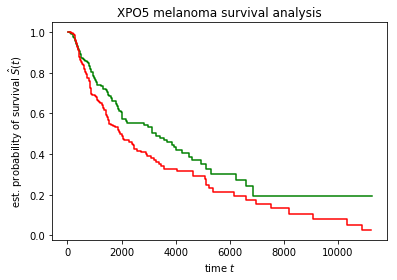

In [141]:
plot_kaplan_meier("XPO5")